# Семинар 4: "Методы оптимизации"

In [1]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

На этом семинаре мы попробуем сравнить различные методы оптимизации.

На семинаре реализуем и сравним методы:
<b>SGD, NAG, Adagrad, RMSProp</b>.



## Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

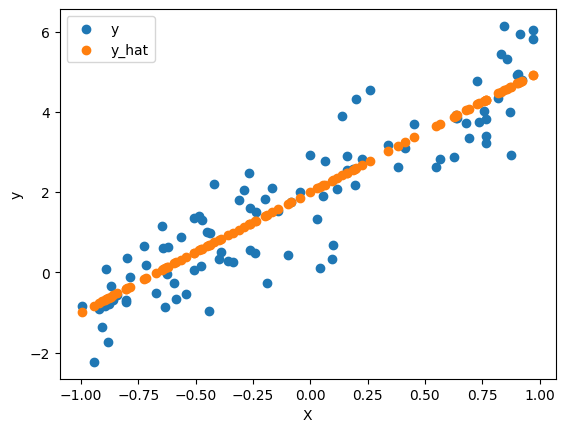

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

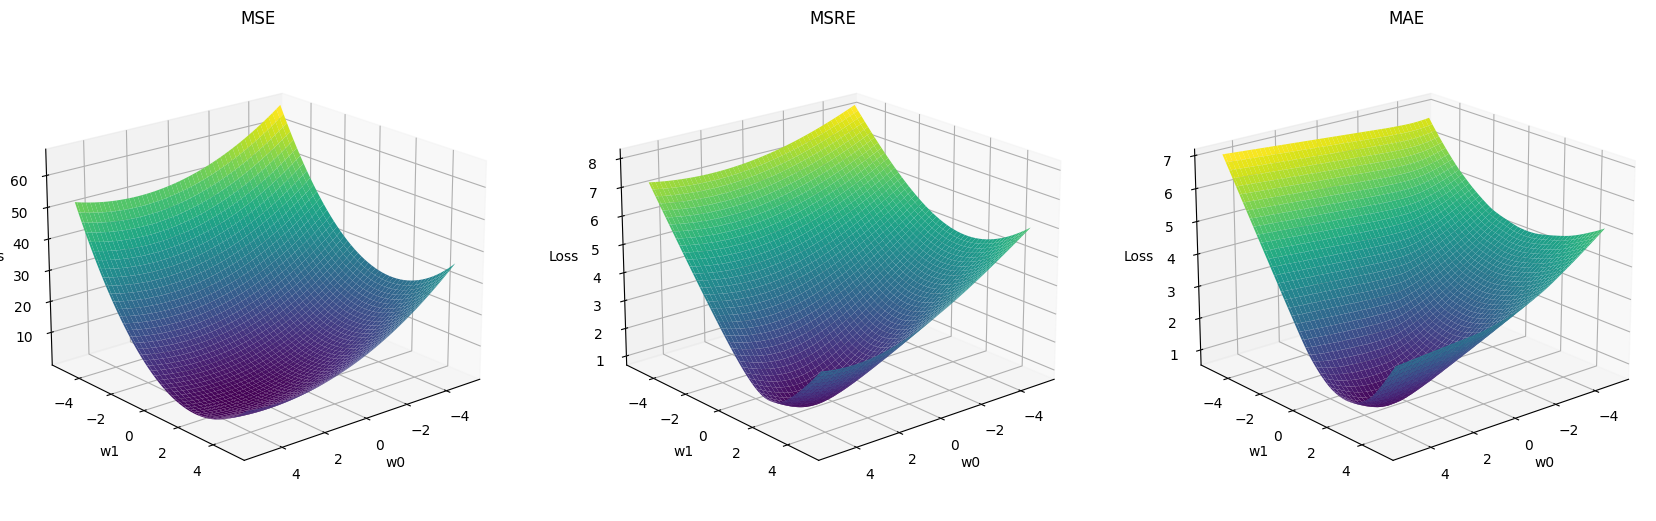

In [4]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

<i> 1.1 Реализуем методы SGD, NAG, Adagrad, RMSProp</i>:

In [5]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [6]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [7]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

### SGD
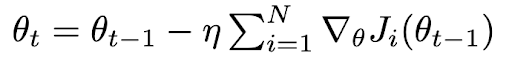

In [8]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is not None:
                    p -= self.lr * p.grad


### Nesterov accelerated gradient
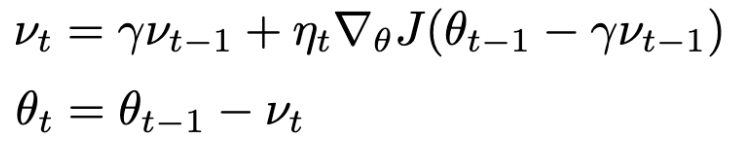

In [9]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:

                    prev_momentum = self.momentum[i]
                    self.momentum = self.gamma * prev_momentum + self.lr * p.grad
                    p -= (1 + self.gamma) * self.momentum[i] - self.gamma * prev_momentum


### AdaGrad
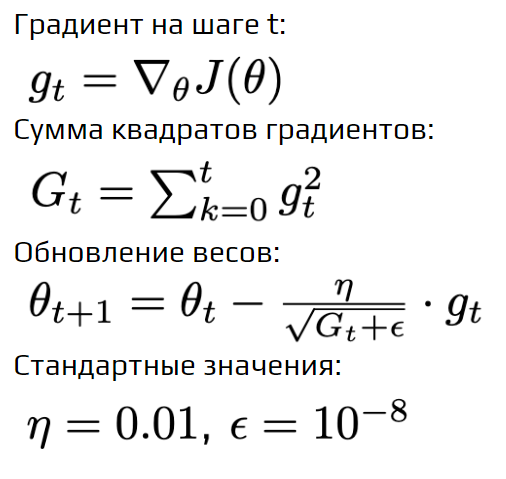

In [10]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)

        self.eta = eta
        self.epsilon = epsilon

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:

                    self.G[i] += p.grad ** 2
                    p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

### RMSProp

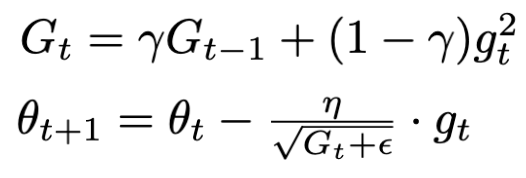

In [11]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9):
        super().__init__(params)

        self.epsilon = epsilon
        self.eta = eta
        self.gamma = gamma

        self.G = [torch.zeros_like(p.data) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:

                    self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)

                    p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad



In [12]:
# from functools import partial

# points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), AdaGrad, {'eta': 1e-8}, start_point=[-4, -4], num_iter=100)

In [13]:
# compare_optimizers(
#     loss_animator,
#     mse,
#     [
#         ['SGD', SGD, {'lr': 1e-1}],
#         ['NAG', NAG, {'lr': 1e-1}],
#         ['AdaGrad', AdaGrad, {'eta': 1}],
#         ['RMSProp', RMSProp, {'eta': 1}],
#     ],
#     start_point=[-4, -4],
#     num_iter=100
# )

В качестве домашней работы вам необходимо будет реализовать и сравнить методы:
<b>Momentum, AdaDelta, Adam</b>.

Также вам будет предложено сравнить реализованные методы при обучении полносвязной и сверточной нейронных сетей на датасете MNIST.



**Momentum optimizer**

In [14]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.momentum = [torch.zeros_like(p.data) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:

                    prev_momentum = self.momentum[i]
                    self.momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                    p -= self.momentum[i]


**Adadelta optimizer**



In [15]:
class Adadelta(Optimizer):
    def __init__(self, params, epsilon=1e-6, eta=1e-1, gamma=0.9):
        super().__init__(params)

        self.epsilon = epsilon
        self.eta = eta
        self.gamma = gamma

        self.G = [torch.zeros_like(p.data) for p in self.params]
        self.teta = [torch.zeros_like(p.data) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:

                    self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)
                    rms_g = torch.sqrt(self.G[i] + self.epsilon)

                    self.teta[i] = self.gamma * self.teta[i] + (1 - self.gamma) * (self.teta[i] ** 2)
                    rms_teta = torch.sqrt(self.teta[i] + self.epsilon)
                    p -= (rms_teta / rms_g) * p.grad


**Adam optimizer**

In [16]:
class Adam(Optimizer):
    def __init__(self, params, eta=1e-2, epsilon=1e-8, beta_1=0.9, beta_2=0.999):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2


        self.m = [torch.zeros_like(p.data) for p in self.params]
        self.v = [torch.zeros_like(p.data) for p in self.params]

        self.iter_counter = 1

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:

                    m_prev = self.m[i]
                    self.m[i] = self.beta_1 * m_prev + (1 - self.beta_1) * p.grad

                    v_prev = self.v[i]
                    self.v[i] = self.beta_2 * v_prev + (1 - self.beta_2) * (p.grad ** 2)

                    m_t = self.m[i] / (1 - (self.beta_1 ** self.iter_counter))
                    v_t = self.v[i] / (1 - (self.beta_2 ** self.iter_counter))

                    p -= self.eta / (torch.sqrt(v_t ) + self.epsilon) * m_t

        self.iter_counter += 1

In [17]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['NAG', NAG, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta': 1}],
        ['RMSProp', RMSProp, {'eta': 1}],
        ['Momentum', Momentum, {'lr':1e-1}],
        ['Adadelta', Adadelta, {'epsilon': 0.25, 'eta': 1e-1}],
        ['Adam', Adam, {'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-2, 'eta': 1}]
    ],
    start_point=[-4, -4],
    num_iter=100
)

In [18]:
import torch as trch
import torchvision.datasets as dts
import torchvision.transforms as trnsfrms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plot

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = MNIST(root='.', train=True, transform=trans, download=True)
test_dataset = MNIST(root='.', train=False, transform=trans)

train_loader = DataLoader(dataset=train_dataset, batch_size=128,shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

img_vec_size = 28 * 28

class FCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(img_vec_size, img_vec_size * 2)
        self.linear2 = nn.Linear(img_vec_size * 2, 50)
        self.final = nn.Linear(50, 10)
        self.relu = nn.ReLU()

    def forward(self, img):
        a = img.reshape(-1, 784)
        a = self.relu(self.linear1(a))
        a = self.relu(self.linear2(a))
        a = self.final(a)
        return a

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential( nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

criterion = nn.CrossEntropyLoss()




def model_train(train_loader, model, optimizer, criterion, num_epochs=5):
    total_step = len(train_loader)
    loss_list = []
    acc_list = []
    for epoch in tqdm(range(num_epochs)):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            # if (i + 1) % 100 == 0:
            #     print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
            #         .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
            #                 (correct / total) * 100))
    return loss_list, acc_list

models_losses = {}
models_accs = {}

models = {'CNN': CNN, 'FCN': FCN}
optimizers = {'Momentum': Momentum, 'Adadelta': Adadelta, 'Adam': Adam}

for model_name, model_value in models.items():
    for optimizer_name, optimizer_value in optimizers.items():
        model = model_value().to(device)
        optimizer = optimizer_value(model.parameters())

        loss_list, acc_list = model_train(train_loader, model, optimizer, criterion)

        models_losses[model_name + '|' + optimizer_name] = loss_list
        models_accs[model_name + '|' + optimizer_name] = acc_list

100%|██████████| 5/5 [01:12<00:00, 14.55s/it]


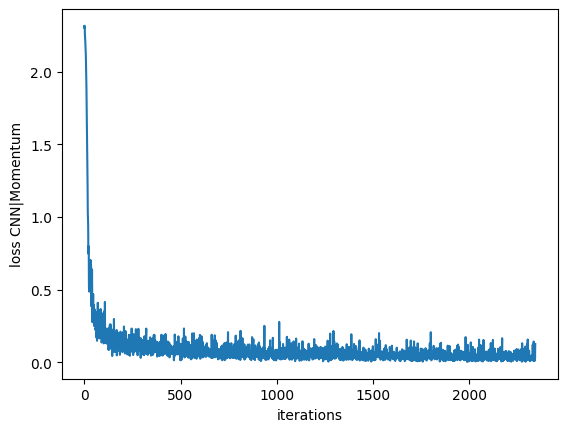

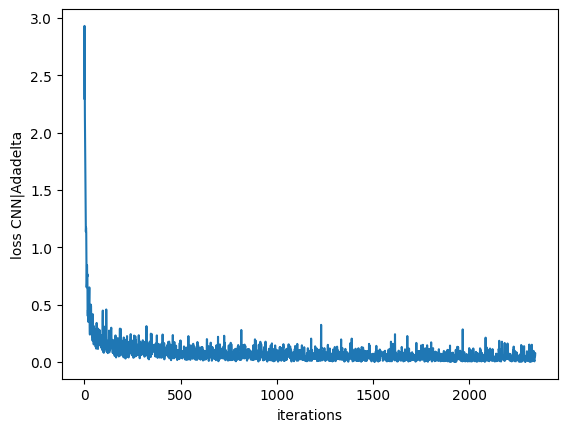

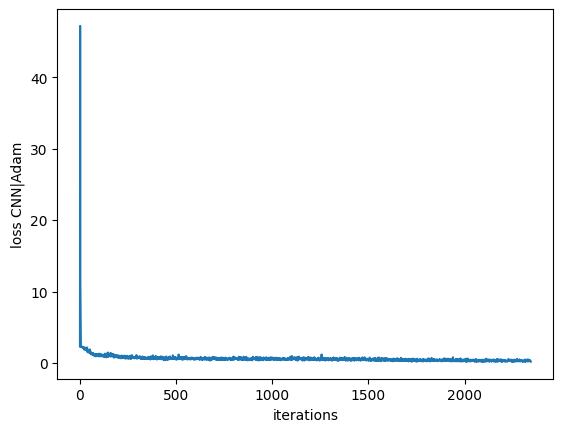

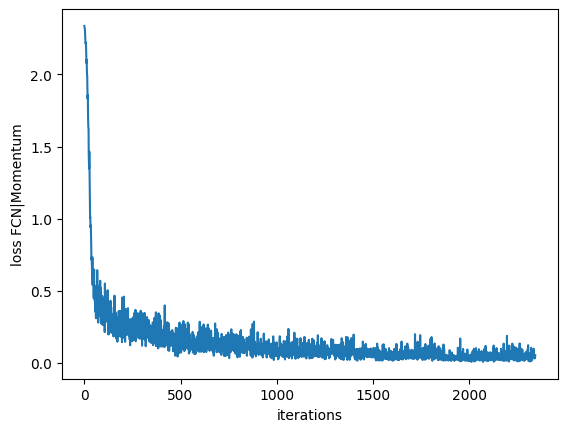

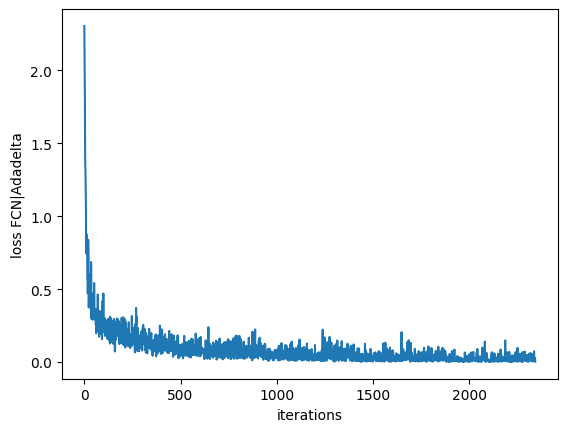

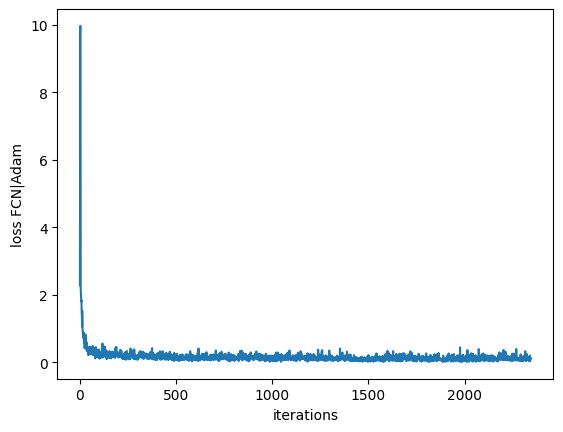

In [19]:
for key, value in models_losses.items():
    plt.plot(value)
    plt.xlabel('iterations')
    plt.ylabel(f'loss {key}')
    plt.show()

**Выводы и пояснения к работе**

Выше описаны реализации всех оптимизаторов, а также архитектуры сверточной нейронной сети и полносвязной. Для того, чтобы ададельта оптимизатор сошелся на тестовом примере, который был на паре, пришлось поставить высокое значение epsilon, однако при использовании такого значения в нейронных сетях они просто ломаются. В параметрах по умолчанию при инициализации класса оптимизатора указаны оптимальные параметры, которые были взяты из оригинальных статей + из документации pytorch. На графика изображено значение функции потерь в зависимости от количества итераций. Можно заметить, что Adam имеет наименее шумную функцию потерь, а также сходится быстрее, чем другие оптимизаторы. Однако изначальная функция потерь имеет огромное значение.